In [125]:
from bs4 import BeautifulSoup as bs
import requests
from tqdm import tqdm 
import json
import os
import datetime
import re
import csv
import time
import pandas as pd
from nltk.stem import *
from collections import Counter
from functools import reduce
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk import tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
# data = load_tsv()
data = pd.read_csv("tsv_dataframe.csv",index_col=0)

#Reset Index
data.reset_index(inplace = True, drop=True)

In [127]:
data.head()

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAdress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedList,placeRelatedPlace,placeURL
0,City Hall Station,"subways,subterranean,infrastructure,subterrane...",1834,8603,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"The Sugar House Prison Window,African Burial G...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,Rebekah OttoAnnetta BlackAllancharding407wythe...,2010-05-08 00:00:00,"African Burial Ground National Monument,Tunnel...","Crystal Palace Subway,Moscow Metro Stations,Ro...",https://www.atlasobscura.com/places/city-hall-...
1,The Winchester Mystery House,"follies and grottoes,outsider architecture,ecc...",3723,5209,In 1886 an eccentric woman named Sarah Winches...,A peculiar mansion built by the troubled heir ...,"Rosicrucian Park,Santana Row Chess Plaza,Rosic...","525 South Winchester Boulevard San Jose, Calif...",37.3189,-121.9506,mbisonAvoiding RegretPrestonWCollinDestination...,2008-11-21 00:00:00,"Santana Row Chess Plaza,Rosicrucian Park,Rosic...","Casa de Piedra (Stone House),Portmeirion Villa...",https://www.atlasobscura.com/places/winchester...
2,Center for Puppetry Arts,"sesame street,puppets,museums",705,1027,"If you know your Gonzo from your Gelflings, yo...",The largest puppetry museum in the USA houses ...,"Breman Museum,The Consulate,Atlanta Monetary M...","1404 Spring St Atlanta, Georgia United States",33.7927,-84.3896,kendallmbaileyMartinandydoesitWe All Pod Down ...,2018-11-12 00:00:00,"Breman Museum,Atlanta Monetary Museum,The Cons...","Portland Puppet Museum,Museu da Marioneta (Mus...",https://www.atlasobscura.com/places/center-for...
3,Amityville Horror House,"hoaxes and pseudoscience,haunted,film location...",367,831,"On a cold November night in 1974, Amityville, ...",The site of a tragic massacre that spawned a m...,"The Long Island Puppet Theater,Fire Island Lig...","112 Ocean Avenue Amityville, New York, 11701 U...",40.6665,-73.4143,EricGrundhauserMandrewPatinkinlendog666MartinR...,2013-10-17 00:00:00,"The Long Island Puppet Theater,Fire Island Lig...","Conanicut Island Lighthouse,Lovell Health Hous...",https://www.atlasobscura.com/places/amityville...
4,Yuma Territorial Prison,"prisons,crime and punishment",422,833,"On July 1, 1876, the first seven inmates enter...",Walk through the actual strap iron cells and s...,"Old Plank Road,Felicity, California: Center of...","1 Prison Hill Rd Yuma, Arizona, 85364 United S...",32.7266,-114.6144,desertfairymbisonCorpseLady84Avoiding RegretEx...,2010-04-01 00:00:00,"Felicity, California: Center of the World,Vall...","Buckley's Cave,Palazzo d'Avalos,Oxford Castle ...",https://www.atlasobscura.com/places/yuma-terri...


In [128]:
print(len(data.columns))

15


In [129]:
data.shape

(1199, 15)

In [130]:
data.info

<bound method DataFrame.info of                          placeName  \
0                City Hall Station   
1     The Winchester Mystery House   
2         Center for Puppetry Arts   
3          Amityville Horror House   
4          Yuma Territorial Prison   
...                            ...   
1194         Old Tunnel Bat Colony   
1195               The Bunny Hutch   
1196                 The Washhouse   
1197      Takeshima Fantasy Museum   
1198    Dead Children's Playground   

                                              placeTags  numPeopleVisited  \
0     subways,subterranean,infrastructure,subterrane...              1834   
1     follies and grottoes,outsider architecture,ecc...              3723   
2                         sesame street,puppets,museums               705   
3     hoaxes and pseudoscience,haunted,film location...               367   
4                          prisons,crime and punishment               422   
...                                              

In [131]:
data.isna().sum()

placeName            0
placeTags            2
numPeopleVisited     0
numPeopleWant        0
placeDesc            0
placeShortDesc       0
placeNearby          0
placeAdress          3
placeAlt             0
placeLong            0
placeEditors         0
placePubDate         0
placeRelatedList     0
placeRelatedPlace    2
placeURL             0
dtype: int64

In [132]:
data.describe().applymap('{:,.2f}'.format)

,numPeopleVisited,numPeopleWant,placeAlt,placeLong
count,"1,199.00","1,199.00","1,199.00","1,199.00"
mean,502.60,"1,143.80",40.43,-62.87
std,576.86,827.83,11.38,59.24
min,13.00,801.00,-77.72,-156.96
25%,177.50,850.00,35.80,-105.20
50%,312.00,917.00,40.67,-80.12
75%,584.00,994.00,45.52,-7.21
max,"4,530.00","8,603.00",68.33,171.72


In [133]:
data.placePubDate
data.placePubDate2 = pd.to_datetime(data.placePubDate)
data.placePubDate2
data.placePubDate2['year'] = data.placePubDate2.dt.year
data.placePubDate2['year']
conteggio = data.placePubDate2['year'].value_counts(dropna=False)
print(conteggio)

2016    161
2013    152
2017    148
2012    105
2010    104
2014    103
2018     96
2015     90
2009     83
2019     65
2011     60
2020     18
2008      9
2021      5
Name: placePubDate, dtype: int64


C:\Users\Marco\AppData\Local\Temp\ipykernel_13176\1678919605.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.placePubDate2 = pd.to_datetime(data.placePubDate)


In [134]:
import seaborn as sns

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of pubblications'),
 Text(0.5, 1.0, 'Number of pubblications per year')]

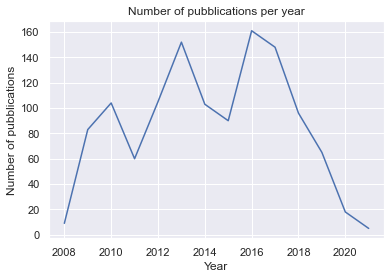

In [135]:
sns.set_theme()
grafico1 = sns.lineplot(data=conteggio)
grafico1.set(xlabel = "Year", ylabel = "Number of pubblications", title = "Number of pubblications per year")

In [136]:
print("L'anno con più pubblicazioni è stato l'anno:", data.placePubDate2['year'].value_counts().idxmax())
print("Il totale di pubblicazioni è stato di:", data.placePubDate2['year'].value_counts()[2016])

L'anno con più pubblicazioni è stato l'anno: 2016
Il totale di pubblicazioni è stato di: 161


In [137]:
top_meta = data.sort_values(["numPeopleVisited"], ascending = False).head(10)
top_meta[["placeName","numPeopleVisited"]]

,placeName,numPeopleVisited
773,Natural History Museum of London,4530
245,Catacombes de Paris,4455
1008,Casa Batlló,3783
1,The Winchester Mystery House,3723
639,Paris Padlocks of Love,3668
27,Grand Central Terminal Whispering Gallery,3629
644,The Last Bookstore,3614
332,Saint Louis Cemetery No. 1,3590
16,La Brea Tar Pits Dragonfly Fossils,3551
313,Rocky Statue,3544


In [138]:
top_futur_meta = data.sort_values(["numPeopleWant"], ascending = False).head(10)
top_futur_meta[["placeName","numPeopleWant"]]

,placeName,numPeopleWant
0,City Hall Station,8603
112,Highgate Cemetery,8206
223,Leadenhall Market,7593
234,The Wave Organ,7422
245,Catacombes de Paris,7057
256,The Evolution Store,6948
267,Magowan's Infinite Mirror Maze,6506
278,Underground Tunnels of Los Angeles,6439
289,Secret Tiled Staircase,6310
311,Dream House,6007


0.4427840231389944


<AxesSubplot:xlabel='numPeopleVisited', ylabel='numPeopleWant'>

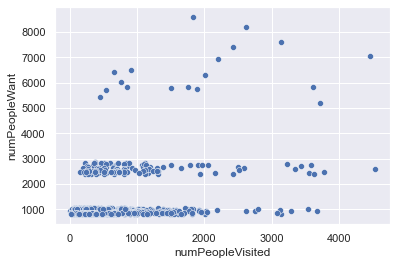

In [139]:
var1 = data.numPeopleVisited
var2 = data.numPeopleWant
print(var1.corr(var2, method = "pearson"))
grafico2 = sns.scatterplot(x="numPeopleVisited", y="numPeopleWant", data=data);
grafico2

In [140]:
data.head()

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAdress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedList,placeRelatedPlace,placeURL
0,City Hall Station,"subways,subterranean,infrastructure,subterrane...",1834,8603,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"The Sugar House Prison Window,African Burial G...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,Rebekah OttoAnnetta BlackAllancharding407wythe...,2010-05-08 00:00:00,"African Burial Ground National Monument,Tunnel...","Crystal Palace Subway,Moscow Metro Stations,Ro...",https://www.atlasobscura.com/places/city-hall-...
1,The Winchester Mystery House,"follies and grottoes,outsider architecture,ecc...",3723,5209,In 1886 an eccentric woman named Sarah Winches...,A peculiar mansion built by the troubled heir ...,"Rosicrucian Park,Santana Row Chess Plaza,Rosic...","525 South Winchester Boulevard San Jose, Calif...",37.3189,-121.9506,mbisonAvoiding RegretPrestonWCollinDestination...,2008-11-21 00:00:00,"Santana Row Chess Plaza,Rosicrucian Park,Rosic...","Casa de Piedra (Stone House),Portmeirion Villa...",https://www.atlasobscura.com/places/winchester...
2,Center for Puppetry Arts,"sesame street,puppets,museums",705,1027,"If you know your Gonzo from your Gelflings, yo...",The largest puppetry museum in the USA houses ...,"Breman Museum,The Consulate,Atlanta Monetary M...","1404 Spring St Atlanta, Georgia United States",33.7927,-84.3896,kendallmbaileyMartinandydoesitWe All Pod Down ...,2018-11-12 00:00:00,"Breman Museum,Atlanta Monetary Museum,The Cons...","Portland Puppet Museum,Museu da Marioneta (Mus...",https://www.atlasobscura.com/places/center-for...
3,Amityville Horror House,"hoaxes and pseudoscience,haunted,film location...",367,831,"On a cold November night in 1974, Amityville, ...",The site of a tragic massacre that spawned a m...,"The Long Island Puppet Theater,Fire Island Lig...","112 Ocean Avenue Amityville, New York, 11701 U...",40.6665,-73.4143,EricGrundhauserMandrewPatinkinlendog666MartinR...,2013-10-17 00:00:00,"The Long Island Puppet Theater,Fire Island Lig...","Conanicut Island Lighthouse,Lovell Health Hous...",https://www.atlasobscura.com/places/amityville...
4,Yuma Territorial Prison,"prisons,crime and punishment",422,833,"On July 1, 1876, the first seven inmates enter...",Walk through the actual strap iron cells and s...,"Old Plank Road,Felicity, California: Center of...","1 Prison Hill Rd Yuma, Arizona, 85364 United S...",32.7266,-114.6144,desertfairymbisonCorpseLady84Avoiding RegretEx...,2010-04-01 00:00:00,"Felicity, California: Center of the World,Vall...","Buckley's Cave,Palazzo d'Avalos,Oxford Castle ...",https://www.atlasobscura.com/places/yuma-terri...


In [141]:
import matplotlib.pyplot as plt

[('of', 170), ('McBride', 122), ('Black', 45), ('Annetta', 34), ('Jackson', 34), ('J', 28), ('Szendrey', 22), ('Jacobson', 22), ('Experiences', 20), ('Luke', 19)]


D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


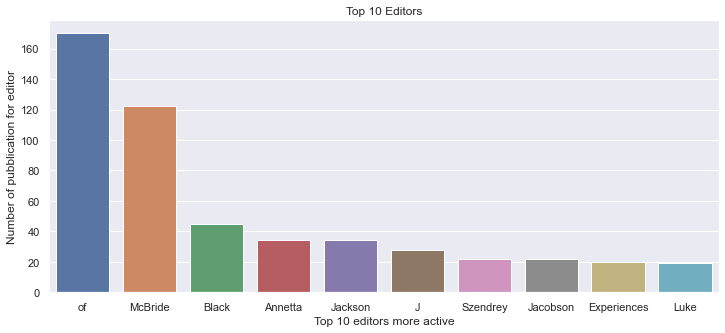

In [165]:
d = {}
n = len(data)

for i in range(n):
    l = []
    l = data.iloc[i]["placeEditors"]
    l = l.split(' ')
    for j in l:
        if not j in d:
            d[j] = 1
        else:
            d[j] = d[j] + 1
top_editors = sorted(d.items(), key=lambda x: x[1], reverse = True)
print(top_editors[:10])

keys = []
values = []
for i in range(10):
    keys.append(top_editors[i][0])
    values.append(top_editors[i][1])

plt.figure(figsize=(12,5))
grafico2 = sns.barplot(keys, values)
grafico2.set(xlabel = "Top 10 editors more active", ylabel = "Number of pubblication for editor", title = "Top 10 Editors")
plt.show()